In [15]:
from keras.preprocessing import image
from mtcnn.mtcnn import MTCNN
import numpy as np
import os

# extract face from image
def extract_face(pixels):
    required_size = (224,224)
    # # load image
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    for res in results:
        x1, y1, width, height = res['box']
        x2, y2 = x1 + width, y1 + height
        # extract face
        face = pixels[y1:y2, x1:x2]
        face = np.array(face, dtype='float')
        # # resize face
        image_t = image.array_to_img(face)
        image_t = image_t.resize(required_size)
        face_array = np.asarray(image_t, dtype='float')
        return face_array
    return np.array([])


def create_data(train_data_dir, list_label_dict, list_label, output_dir='', use_mtcnn_extract_face=False):
    data_x = []
    data_y = []
    for person in list_label:
        train_data_dir_1 = train_data_dir + person + '/'
        list_image = os.listdir(train_data_dir_1)
        if output_dir != '':
            output_dir_1 = output_dir + person
            os.mkdir(output_dir_1)
        for img_file in list_image:
            img_load = image.load_img(train_data_dir_1 + img_file, target_size=(224, 224))
            img_load = np.asarray(img_load)
            if use_mtcnn_extract_face:
                img_load = extract_face(img_load)
            if img_load.size != 0:
                if output_dir != '':
                    image.array_to_img(img_load).save(output_dir_1 + '/' + img_file)
                data_x.append(img_load)
                temp = np.zeros(10, dtype='int')
                temp[list_label_dict[person]] = 1
                data_y.append(temp)
    data_x = np.asarray(data_x)
    data_y = np.asarray(data_y)
    return data_x, data_y


train_data_dir_ = './vgg_face_data/traindata_mtcnn/'
validation_data_dir_ = './vgg_face_data/testdata_mtcnn/'

list_label_ = os.listdir(train_data_dir_)
label_dict = {}
for i in range(0, 10):
    label_dict[list_label_[i]] = i
# create data
train_X, train_y = create_data(train_data_dir_, label_dict, list_label_)
validation_X, validation_y = create_data(validation_data_dir_, label_dict, list_label_)

In [16]:
def add_dense_layer(vgg16_pre_train_model, num_class, D=712):
    """creates the top or head of the model that will be
    placed on top of the bottom layers"""
    face_model = vgg16_pre_train_model.output
    face_model = Flatten(name="flatten")(face_model)
    face_model = Dense(D, activation="relu")(face_model)
    face_model = Dropout(0.5)(face_model)
    face_model = Dense(D, activation="relu")(face_model)
    face_model = Dropout(0.5)(face_model)
    face_model = Dense(D, activation="relu")(face_model)
    face_model = Dropout(0.5)(face_model)
    face_model = Dense(num_class, activation="softmax")(face_model)
    return face_model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.applications import vgg16

# vgg 16 was designed to work on 224*224 pixel input images sizes
height_size = 224
width_size = 224

# loads the VGG16 model
model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(height_size, width_size, 3))

# Here we free the last 4 layers
# layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False

# Let's print our layers
for (i, layer) in enumerate(model.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

num_classes = len(list_label_)
FC_Head = add_dense_layer(model, num_classes)
face_reg_model = Model(inputs=model.input, outputs=FC_Head)

print(face_reg_model.summary())

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                             

Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 48.3573 - accuracy: 0.2659  

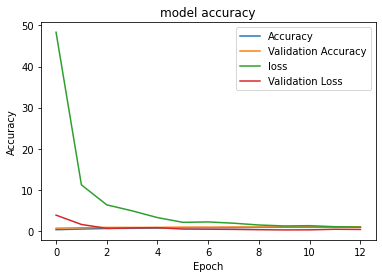

In [18]:
from keras.optimizers import rmsprop_v2
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
checkpoint = ModelCheckpoint("face_VGG.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)
# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate
face_reg_model.compile(loss="categorical_crossentropy",
                 optimizer=rmsprop_v2.RMSProp(learning_rate=0.001),
                 metrics=['accuracy'])

nb_train_samples = 891
nb_validation_samples = 151

epochs = 20
batch_size = 16

history = face_reg_model.fit(
    x=train_X, y=train_y,
    steps_per_epoch=nb_train_samples//batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(validation_X, validation_y),
    validation_steps=nb_validation_samples//batch_size)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_accuracy.jpg')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss.jpg')
plt.show()

[4.6885662e-32 2.4029791e-22 5.3578685e-22 1.9562291e-26 1.0000000e+00
 8.1095236e-25 1.5077567e-20 1.7488012e-13 1.1773929e-24 1.0031769e-34]
Model predict this face belong to Abbie_Cornish
Label of this is Abbie_Cornish


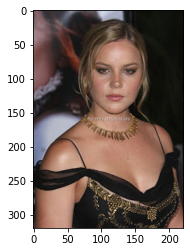

{0: 'Aamir_Khan', 1: 'Aaron_Staton', 2: 'Aaron_Tveit', 3: 'Aaron_Yoo', 4: 'Abbie_Cornish', 5: 'Abel_Ferrara', 6: 'Abigail_Breslin', 7: 'Abigail_Klein', 8: 'Abigail_Spencer', 9: 'Abraham_Benrubi'}
[2.1425184e-07 5.5720596e-07 6.5081513e-05 1.1357541e-06 2.4016409e-03
 3.9740986e-05 9.9739957e-01 9.1060545e-05 9.9108536e-07 2.5133941e-08]
Model predict this face belong to Abigail_Breslin
Label of this is Abigail_Breslin


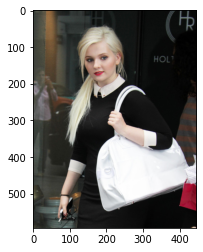

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from keras.models import load_model
from keras.preprocessing import image

def extract_face(pixels):
    required_size = (224,224)
    # # load image
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    for res in results:
        x1, y1, width, height = res['box']
        x2, y2 = x1 + width, y1 + height
        # extract face
        face = pixels[y1:y2, x1:x2]
        face = np.array(face, dtype='float')
        # # resize face
        image_t = image.array_to_img(face)
        image_t = image_t.resize(required_size)
        face_array = np.asarray(image_t, dtype='float')
        return face_array
    return np.array([])


face_detector = load_model('face_VGG.h5')

face_dict = {}
img_dir = './vgg_face_data/testdata/'
list_folder = os.listdir(img_dir)
for i in range(0, 10):
    face_dict[i] = list_folder[i]
print(face_dict)
img_name = random.choice(list_folder)
img_dir += img_name + '/'
img_dir += random.choice(os.listdir(img_dir))
img = image.load_img(img_dir, grayscale=False, color_mode='rgb')
img = np.asarray(img)
img_face = extract_face(img)
plt.imshow(img)
img_face = img_face.reshape((1, 224, 224, 3))
output = face_detector.predict(img_face)

output = np.array(output[0])
print(output)
print('Model predict this face belong to {}'.format(face_dict[output.argmax()]))
print('Label of this is {}'.format(img_name))


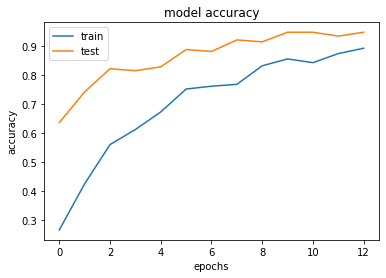

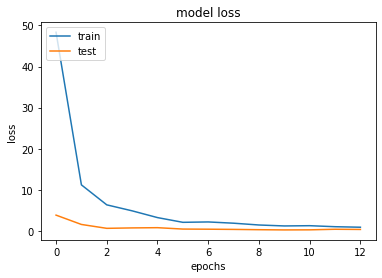